In [18]:
!nvidia-smi

Mon Nov  4 18:38:38 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.52.04              Driver Version: 555.52.04      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off |   00000000:20:00.0 Off |                  N/A |
| 30%   25C    P8              4W /  250W |   10985MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
torch.cuda.empty_cache()

In [2]:
import torch  
import torchvision  
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor  
from torchvision.datasets import CocoDetection  
from torchvision.transforms import functional as F  
from torch.utils.data import DataLoader  
from PIL import Image  
import matplotlib.pyplot as plt  
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm 
import numpy as np 

In [4]:
# Custom collate function for handling lists of dictionaries  
def collate_fn(batch):  
    return tuple(zip(*batch))  
  
# Set device  
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  
  
# Define paths  
dataset_dir = '/home/susmoh-3/r7020_cvip/data/fire_extinguiser/coco'  
train_img_dir = f'{dataset_dir}/train'  
train_ann_file = f'{dataset_dir}/train/_annotations.coco.json'  
test_img_dir = f'{dataset_dir}/valid'  
test_ann_file = f'{dataset_dir}/valid/_annotations.coco.json'  
  
# Load COCO dataset for training  
train_dataset = CocoDetection(root=train_img_dir, annFile=train_ann_file, transform=F.to_tensor)  
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)  
  
# Load the pre-trained model and modify for specific number of classes  
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT  
model = fasterrcnn_resnet50_fpn(weights=weights)  
  
num_classes = 2  # 1 class (fire extinguisher) + background  
  
# Get the number of input features for the classifier  
in_features = model.roi_heads.box_predictor.cls_score.in_features  
  
# Replace the pre-trained head with a new one  
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)  
  
# Move model to the appropriate device  
model.to(device)  
  
# Define optimizer  
params = [p for p in model.parameters() if p.requires_grad]  
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)  
  
# Training loop  
num_epochs = 10  
for epoch in range(num_epochs):  
    model.train()  
    epoch_loss = 0  
    num_batches = 0  
      
    # Wrap the train_loader with tqdm  
    with tqdm(train_loader, unit="batch") as tepoch:  
        for images, targets in tepoch:  
            tepoch.set_description(f"Epoch {epoch + 1}")  
  
            images = list(image.to(device) for image in images)  
              
            # Process each target for the batch  
            processed_targets = []  
            for target in targets:  
                if len(target) == 0:  # If there are no annotations  
                    processed_target = {  
                        'boxes': torch.zeros((0, 4), dtype=torch.float32).to(device),  
                        'labels': torch.zeros((0,), dtype=torch.int64).to(device)  
                    }  
                else:  
                    boxes = [obj['bbox'] for obj in target]  # Extract 'bbox'  
                    labels = [obj['category_id'] for obj in target]  # Extract 'category_id'  
                      
                    # Convert boxes from [x_min, y_min, width, height] to [x_min, y_min, x_max, y_max]  
                    boxes = torch.tensor(boxes, dtype=torch.float32)  
                    boxes[:, 2:] += boxes[:, :2]  # width -> x_max, height -> y_max  
                      
                    # Filter out invalid boxes  
                    valid_boxes = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])  
                    #if not valid_boxes.all():  
                        #print("Invalid boxes detected:", boxes[~valid_boxes])  
                      
                    # Keep only valid boxes and labels  
                    boxes = boxes[valid_boxes]  
                    labels = torch.tensor(labels, dtype=torch.int64)[valid_boxes]  
                      
                    if boxes.shape[0] == 0:  # Handle case where all boxes are invalid  
                        processed_target = {  
                            'boxes': torch.zeros((0, 4), dtype=torch.float32).to(device),  
                            'labels': torch.zeros((0,), dtype=torch.int64).to(device)  
                        }  
                    else:  
                        processed_target = {'boxes': boxes.to(device), 'labels': labels.to(device)}  
                  
                processed_targets.append(processed_target)  
              
            # Zero the parameter gradients  
            optimizer.zero_grad()  
              
            # Forward pass to get the model outputs and compute the loss  
            loss_dict = model(images, processed_targets)  
            losses = sum(loss for loss in loss_dict.values())  
              
            # Backward pass and optimize  
            losses.backward()  
            optimizer.step()  
              
            # Accumulate loss  
            epoch_loss += losses.item()  
            num_batches += 1  
              
            # Update tqdm progress bar with current loss  
            tepoch.set_postfix(loss=losses.item())  
      
    # Report average loss per epoch  
    average_loss = epoch_loss / num_batches  
    print(f"Epoch {epoch+1}, Average Loss: {average_loss:.4f}")  

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


Epoch 1: 100%|██████████| 734/734 [07:49<00:00,  1.56batch/s, loss=0.161] 


Epoch 1, Average Loss: 0.1563


Epoch 2: 100%|██████████| 734/734 [07:50<00:00,  1.56batch/s, loss=0.0796]


Epoch 2, Average Loss: 0.1107


Epoch 3: 100%|██████████| 734/734 [07:53<00:00,  1.55batch/s, loss=0.0433]


Epoch 3, Average Loss: 0.0969


Epoch 4: 100%|██████████| 734/734 [07:51<00:00,  1.56batch/s, loss=0.0924]


Epoch 4, Average Loss: 0.0854


Epoch 5: 100%|██████████| 734/734 [07:53<00:00,  1.55batch/s, loss=0.0532]


Epoch 5, Average Loss: 0.0794


Epoch 6: 100%|██████████| 734/734 [07:49<00:00,  1.56batch/s, loss=0.0415]


Epoch 6, Average Loss: 0.0753


Epoch 7: 100%|██████████| 734/734 [07:53<00:00,  1.55batch/s, loss=0.019] 


Epoch 7, Average Loss: 0.0702


Epoch 8: 100%|██████████| 734/734 [07:51<00:00,  1.56batch/s, loss=0.0474]


Epoch 8, Average Loss: 0.0651


Epoch 9: 100%|██████████| 734/734 [07:50<00:00,  1.56batch/s, loss=0.0886]


Epoch 9, Average Loss: 0.0637


Epoch 10: 100%|██████████| 734/734 [07:56<00:00,  1.54batch/s, loss=0.0518]

Epoch 10, Average Loss: 0.0627


In [5]:
# After training, save the model  
model_save_path = '/home/susmoh-3/r7020_cvip/models/fasterrcnn_model_1.pth'  
torch.save(model.state_dict(), model_save_path) 

In [6]:
# Define a function to calculate IoU  
def calculate_iou(boxA, boxB):  
    xA = max(boxA[0], boxB[0])  
    yA = max(boxA[1], boxB[1])  
    xB = min(boxA[2], boxB[2])  
    yB = min(boxA[3], boxB[3])  
  
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)  
  
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)  
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)  
  
    iou = interArea / float(boxAArea + boxBArea - interArea)  
  
    return iou  
  
# Function to match predictions to ground truths  
def match_predictions_to_ground_truths(pred_boxes, pred_labels, gt_boxes, gt_labels, iou_threshold=0.5):  
    TP, FP, FN = 0, 0, 0  
    matched_indices = set()  
  
    for pred_box, pred_label in zip(pred_boxes, pred_labels):  
        best_iou = 0  
        best_gt_idx = -1  
  
        for i, (gt_box, gt_label) in enumerate(zip(gt_boxes, gt_labels)):  
            if gt_label == pred_label and i not in matched_indices:  
                iou = calculate_iou(pred_box, gt_box)  
                if iou > best_iou:  
                    best_iou = iou  
                    best_gt_idx = i  
  
        if best_iou > iou_threshold:  
            TP += 1  
            matched_indices.add(best_gt_idx)  
        else:  
            FP += 1  
  
    FN = len(gt_boxes) - len(matched_indices)  
  
    return TP, FP, FN  

In [7]:
# Load COCO dataset for validation  
val_dataset = CocoDetection(root=test_img_dir, annFile=test_ann_file, transform=F.to_tensor)  
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn)  
  
# Inference and evaluation  
model.eval()  
all_TP, all_FP, all_FN = 0, 0, 0  
  
for images, targets in val_loader:  
    images = list(image.to(device) for image in images)  
    outputs = model(images)  
      
    processed_targets = []  
    for target in targets:  
        if len(target) == 0:  
            processed_target = {  
                'boxes': torch.zeros((0, 4), dtype=torch.float32),  
                'labels': torch.zeros((0,), dtype=torch.int64)  
            }  
        else:  
            boxes = [obj['bbox'] for obj in target]  
            labels = [obj['category_id'] for obj in target]  
  
            boxes = torch.tensor(boxes, dtype=torch.float32)  
            boxes[:, 2:] += boxes[:, :2]  
  
            valid_boxes = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])  
            boxes = boxes[valid_boxes]  
            labels = torch.tensor(labels, dtype=torch.int64)[valid_boxes]  
  
            if boxes.shape[0] == 0:  
                processed_target = {  
                    'boxes': torch.zeros((0, 4), dtype=torch.float32),  
                    'labels': torch.zeros((0,), dtype=torch.int64)  
                }  
            else:  
                processed_target = {'boxes': boxes, 'labels': labels}  
  
        processed_targets.append(processed_target)  
  
    for output, processed_target in zip(outputs, processed_targets):  
        pred_boxes = output['boxes'].cpu().detach().numpy()  
        pred_labels = output['labels'].cpu().detach().numpy()  
  
        gt_boxes = processed_target['boxes'].numpy()  
        gt_labels = processed_target['labels'].numpy()  
  
        TP, FP, FN = match_predictions_to_ground_truths(pred_boxes, pred_labels, gt_boxes, gt_labels)  
  
        all_TP += TP  
        all_FP += FP  
        all_FN += FN  
  
# Calculate precision, recall, and F1 score  
precision = all_TP / (all_TP + all_FP) if (all_TP + all_FP) > 0 else 0  
recall = all_TP / (all_TP + all_FN) if (all_TP + all_FN) > 0 else 0  
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0  
  
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")  

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Precision: 0.6155, Recall: 0.9538, F1 Score: 0.7482


In [8]:
# Function to plot a grid of images with bounding boxes  
def plot_images_with_boxes(images, outputs_list, threshold=0.5):  
    num_images = len(images)  
    grid_size = int(np.ceil(np.sqrt(num_images)))  
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))  
      
    # Ensure axs is always a 2D array  
    if grid_size == 1:  
        axs = np.array([[axs]])  
    elif grid_size == 2:  
        axs = np.array([[axs[0], axs[1]], [axs[2], axs[3]]])  
  
    for idx, (img, outputs) in enumerate(zip(images, outputs_list)):  
        ax = axs[idx // grid_size, idx % grid_size]  
        img = img.permute(1, 2, 0).cpu().numpy()  
        ax.imshow(img)  
          
        for box, score in zip(outputs['boxes'], outputs['scores']):  
            if score > threshold:  
                x1, y1, x2, y2 = box.cpu().detach().numpy()  
                rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2)  
                ax.add_patch(rect)  
          
        ax.axis('off')  
      
    # Hide remaining subplots  
    for idx in range(num_images, grid_size * grid_size):  
        axs[idx // grid_size, idx % grid_size].axis('off')  
  
    plt.tight_layout()  
    plt.show()  
  
def collect_images_and_outputs(val_loader, num_images=16):  
    collected_images = []  
    collected_outputs = []  
      
    with torch.no_grad():  
        for images, _ in val_loader:  
            images = [image.to(device) for image in images]  
            outputs = model(images)  
              
            collected_images.extend(images)  
            collected_outputs.extend(outputs)  
              
            if len(collected_images) >= num_images:  
                break  
      
    return collected_images[:num_images], collected_outputs[:num_images]  

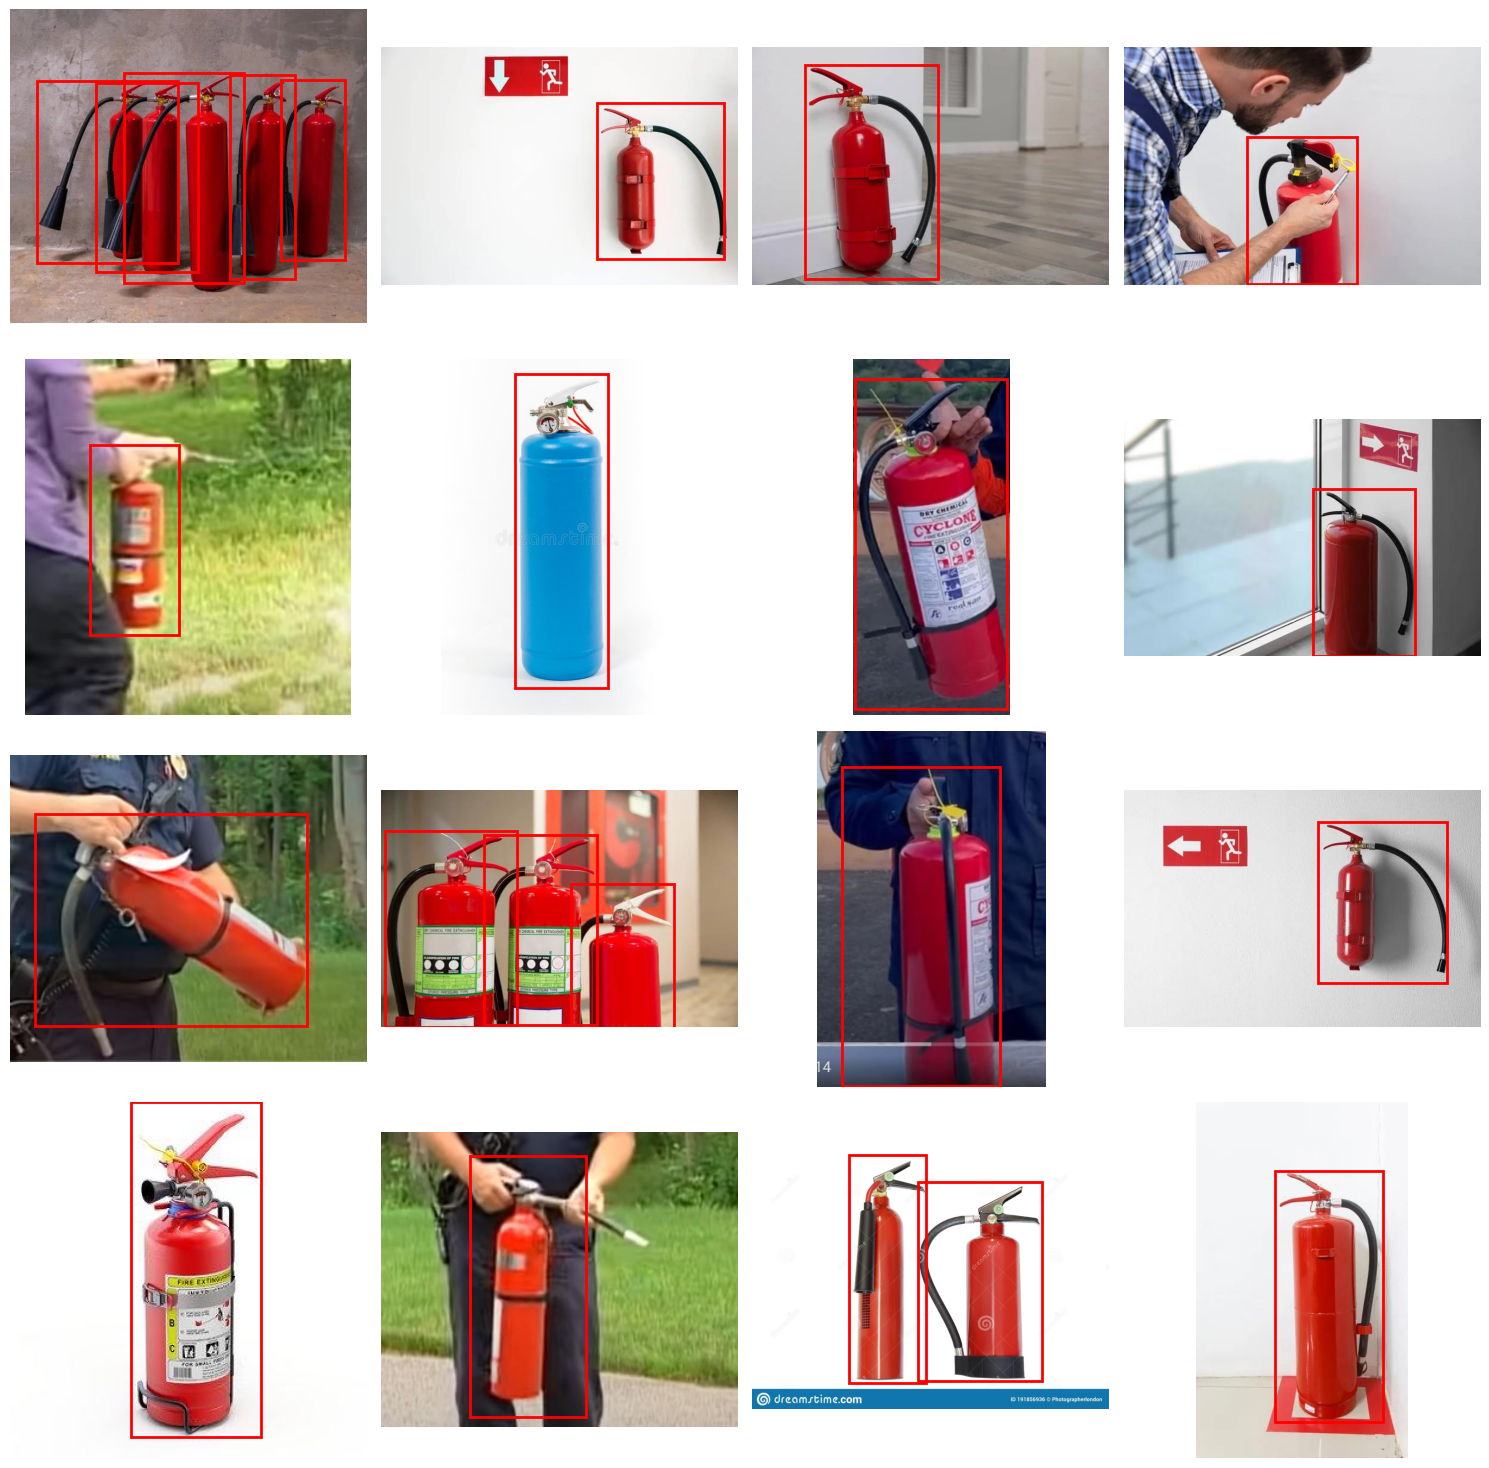

In [9]:
# Collect images and their outputs  
images, outputs_list = collect_images_and_outputs(val_loader, num_images=16)  
  
# Plot the images with their bounding boxes  
plot_images_with_boxes(images, outputs_list) 